# Training a spiking neural network for classifying the MNIST dataset

In [1]:
import time

import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd

#! pip install brainpy_datasets
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np

/Users/charlie/Miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bm.set_dt(1.0)

## Introduction  

The last months have seen a surge of interest in training spiking neural networks to do meaningful computations. On the one hand, this surge was fueled by the limited accomplishment of more traditional, and often considered more biologically plausible, learning paradigms in creating functional neural networks that solve interesting computational problems. This limitation was met by the undeniable success of deep neural networks in acing a diversity of challenging computational problems. A success that has raised both the bar and the question of how well this progress would translate to spiking neural networks.  

The rise of deep learning over the last decade is in large part due to GPUs and their increased computational power, growing training data sets, and --- perhaps most importantly --- advances in understanding the quirks and needs of the error back-propagation algorithm. For instance, we now know that we have to avoid vanishing and exploding gradients, a feat that can be accomplished by choice of a sensible nonlinearity, proper weight initialization, and a suitable optimizer. Powerful software packages supporting auto-differentiation have since made mangling with deep neural networks a breeze in comparison to what it used to be. This development begs the question of how much of this knowledge gain from deep learning and its tools we can leverage to train spiking neural networks. Although a complete answer to these questions cannot be given at the moment, it seems that we can learn a lot.  

In this tutorial, we use insights and tools from machine learning to build, step-by-step, a spiking neural network. Explicitly, we set out with the goal of building networks that solve (simple) real-world problems. To that end, we focus on classification problems and use supervised learning in conjunction with the aforementioned back-propagation algorithm. To do this, we have to overcome a vanishing gradient problem caused by the binary nature of the spikes themselves.  

In this tutorial, we will first show how a simple feed-forward spiking neural network of leaky integrate-and-fire (LIF) neurons with current-based synapses can be formally mapped to a discrete-time recurrent neural network (RNN). We will use this formulation to explain why gradients vanish at spikes and show one way of how the problem can be alleviated. Specifically, we will introduce surrogate gradients and provide practical examples of how they can be implemented in BrainPy.

## Mapping LIF neurons to RNN dynamics  

The de-facto standard neuron model for network simulations in computational neuroscience is the LIF neuron model which is often formally written as a time continuous dynamical system in differential form:  
$$\tau_\mathrm{mem} \frac{\mathrm{d}U_i^{(l)}}{\mathrm{d}t} = -(U_i^{(l)}-U_\mathrm{rest}) + RI_i^{(l)}$$  
where $U_i$ is the membrane potential of neuron $i$ in layer $l$, $U_\mathrm{rest}$ is the resting potential, $\tau_\mathrm{mem}$ is the membrane time constant, $R$ is the input resistance, and $I_i$ is the input current. The membrane potential $U_i$ characterizes the hidden state of each neuron and, importantly, it is not directly communicated to downstream neurons. However, a neuron fires an action potential or spike at the time $t$ when its membrane voltage exceeds the firing threshold $\vartheta$. After having fired a spike, a neurons membrane voltage is reset $U_i \rightarrow U_\mathrm{rest}$. We write  
$$S_i^{(l)}(t)=\sum_{k \in C_i^l} \delta(t-t_j^k)$$  
for the spike train (ie. the sum of all spikes $C_i^l$ emitted by neuron $i$ in layer $l$). Here $\delta$ is the Dirac delta function and $t_i^k$ are the associated firing times of the neuron.  

Spikes travel down the axon and generate a postsynaptic currents in connected neurons. Using our above formalism we can thus write  
$$\frac{\mathrm{d}I_i}{\mathrm{d}t}= -\frac{I_i(t)}{\tau_\mathrm{syn}} + \sum_j W_{ij} S_j^{(0)}(t) + \sum_j V_{ij} S_j^{(1)}(t)$$  
where we have introduced the synaptic weight matrices $W_{ij}$ (feed-forward), $V_{ij}$ (recurrent), and the synaptic decay time constant $\tau_\mathrm{syn}$.  

To link to RNNs apparent, we will now express the above equations in discrete time. In the interest of brevity we switch to natural units $U_\mathrm{rest}=0$, $R=1$, and $\vartheta=1$. Our arguments remain unaffected by this choice, and all results can always be re-scaled back to physical units. To highlight the nonlinear character of a spike, we start by noting that we can set  
$$S_i^{(l)}(t)=\Theta(U_i^{(l)}(t)-\vartheta)$$  
where $\Theta$ denotes the Heaviside step function.  

Assuming a small simulation time step of $\Delta_t>0$ we can approximate the synaptic dynamics by  

$$I_i^{(l)}(t+1) = \alpha I_i^{(l)}(t) + \sum_j W_{ij} S_j^{(l-1)}(t) +\sum_j V_{ij} S_j^{(l)}(t)$$  

with the constant $\alpha=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{syn}} \right)$. Further, the membrane dynamics can be written as  
$$U_i^{(l)}(t+1) = \underbrace{\beta U_i^{(l)}(t)}_{\mathrm{leak}} + \underbrace{I_i^{(l)}(t)}_{\mathrm{input}} -\underbrace{S_i^{(l)}(t)}_{\mathrm{reset}}$$  

with the output $S_i(t) = \Theta(U_i(t)-1)$ and the constant $\beta=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{mem}}\right)$. Note the distinct terms on the right-hand-side of the equation which are responsible individually for i) leak, ii) synaptic input, and iii) the spike reset.  


These equations can be summarized succinctly as the computational graph of an RNN with a specific connectivity structure.  
 
<img src="figs/snn_graph.png" width="450">  

Time flows from left to right. Inputs enter the network at each time step from the bottom of the graph ($S_i^{(0)}$). These inputs sequentially influence the synaptic currents $I_i^{(1)}$, membrane potentials the $U_i^{(1)}$, and finally the spiking output $S_i^{(1)}$.  Moreover, dynamic quantities have direct input on future time steps. We have suppressed the indices $i$ in the figure for clarity.  

The computational graph illustrates a concept which is known as unrolling in time, which emphasizes the duality between a deep neural network and a recurrent neural network, which is nothing more but a deep network in time (with tied weights). Due to this fact, we can train RNNs using the back-propagation of error through time (BPTT). We will discuss problems arising from the binary character of the spiking nonlinearity later. For now, let us start by implementing the above dynamics in a three-layer spiking neural network in BrainPy.

# The three-layer SNN network  

Let's start with a simple three-layer network model with a single hidden layer, as shown below.  

<img src="figs/mlp_sketch.png" width="450">  


In [3]:
class Exponential(bp.Projection):
    def __init__(self, num_pre, post, scale=20., tau=10.):
        super().__init__()
        self.proj = bp.dyn.ProjAlignPostMg1(
            comm=bp.dnn.Linear(num_pre, post.num, W_initializer=bp.init.KaimingNormal(scale=scale)),
            syn=bp.dyn.Expon.desc(post.num, tau=tau),
            out=bp.dyn.CUBA.desc(),
            post=post, 
        )

In [4]:
class SNN(bp.DynSysGroup):
  def __init__(self, num_in, num_rec, num_out, scale=10.):
    super(SNN, self).__init__()

    # parameters
    self.num_in = num_in
    self.num_rec = num_rec
    self.num_out = num_out
    # recurrent: r

    # TODO: instantiate LIF neuron group
    # Parameters: tau=10, V_rest=0m V_rest=0, V_th=1.


    #TODO: instantiate Exponential synapse from input to recurrent group, i.e. i->r


    # TODO: instantiate Exponential synapse from recurrent to recurrent group, i.e. r->r

    # output: o
    self.readout = bp.Sequential(
      bp.dnn.Linear(num_rec, num_out, W_initializer=bp.init.KaimingNormal(scale=20.)),
      bp.dyn.Expon(num_out, tau=10.),
      bp.dyn.Leaky(num_out, tau=5)
    )

  def update(self, spike):
    # TODO: network forward call, return readout output



  def reset_state(self, *arg, **kwarg):
    return


In [5]:
def plot_voltage_traces(mem, spk=None, dim=(3, 5), spike_height=5):
  gs = GridSpec(*dim)
  mem = 1. * mem
  if spk is not None:
    mem[spk > 0.0] = spike_height
  mem = bm.as_numpy(mem)
  for i in range(np.prod(dim)):
    if i == 0:
      a0 = ax = plt.subplot(gs[i])
    else:
      ax = plt.subplot(gs[i], sharey=a0)
    ax.plot(mem[:, i])
  plt.tight_layout()
  plt.show()

# A simple synthetic dataset  

We start by generating some random spiking data set, which we will use as input to our network. In the beginning, we will work with a single batch of data. It will be straight forward to expand later what we have learned to larger datasets.  

Suppose we want our network to classify a set of different sparse input spike trains into two categories.  

To generate some synthetic data, we fill a tensor of (batch_size x nb_steps x nb_inputs) with random uniform numbers between 0 and 1 and use this to generate our input dataset:

In [6]:
def print_classification_accuracy(output, target):
  """ Dirty little helper function to compute classification accuracy. """
  m = bm.max(output, axis=0)  # max over time
  am = bm.argmax(m, axis=1)  # argmax over output units
  acc = bm.mean(target == am)  # compare to labels
  print("Accuracy %.3f" % acc)

In [7]:
num_in = 100
num_step = 500
num_sample = 256
freq = 5  # Hz
mask = bm.random.rand(num_step, num_sample, num_in)
x_data = bm.zeros((num_step, num_sample, num_in))
x_data[mask < freq * bm.get_dt() / 1000.] = 1.0
y_data = bm.asarray(bm.random.rand(num_sample) < 0.5, dtype=bm.float_)

If the plot the spike raster of the first input pattern, this synthetic dataset looks as follows.

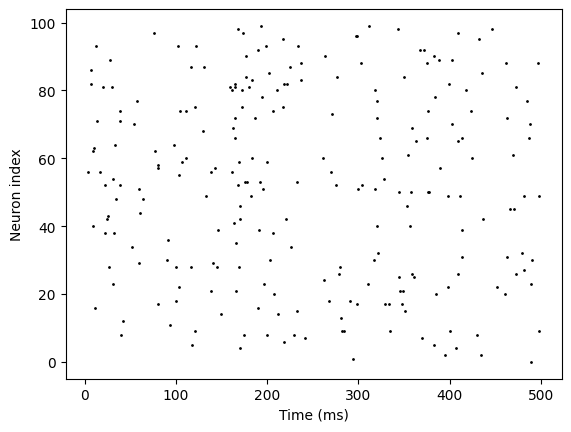

In [8]:
bp.visualize.raster_plot(np.arange(num_step), x_data[:, 0], show=True)

In [9]:
with bm.environment(bm.TrainingMode(batch_size=num_sample)):
    net = SNN(num_in, num_rec=4, num_out=2, scale=10.)


#### Brefore training  

Before training, the accurracy and the spiking dynamics of the network is shown as:

In [10]:
runner = bp.DSRunner(net, monitors={'r.spike': net.r.spike, 'r.membrane': net.r.V}, data_first_axis='T')
out = runner.run(inputs=x_data, reset_state=True)

Predict 500 steps: :   0%|          | 0/500 [00:00<?, ?it/s]Predict 500 steps: : 100%|██████████| 500/500 [00:00<00:00, 1060.33it/s]


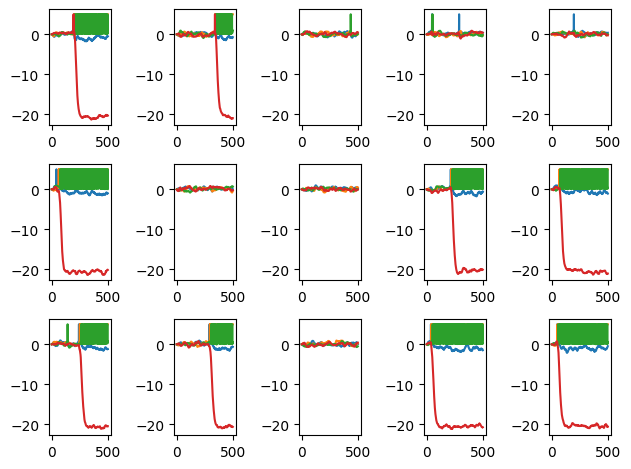

In [11]:
# recurrent membrane potential
plot_voltage_traces(runner.mon.get('r.membrane'), runner.mon.get('r.spike'))

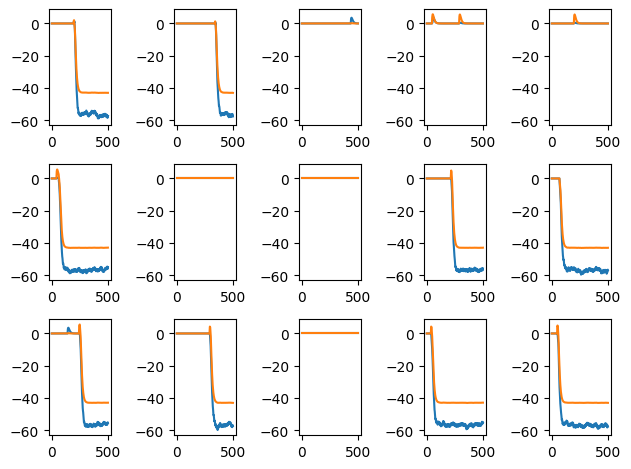

In [12]:
# output activity
plot_voltage_traces(out)

In [13]:
# classification accuracy
print_classification_accuracy(out, y_data)

Accuracy 0.500


#### Training

In [14]:
class Trainer():
    def __init__(self, net, opt, data):
        self.net = net
        self.opt = opt
        self.opt.register_train_vars(net.train_vars().unique())
        self.grad = bm.grad(self.loss, grad_vars=net.train_vars().unique(), return_value=True)
        self.data = data

    def loss(self, X, Y):
        # reset states
        self.net.reset(X.shape[1])
        
        # runnings
        predictions = bm.for_loop(self.net.step_run, (np.arange(X.shape[0]), X))
        predictions = bm.max(predictions, axis=0)  # MAX over time
        l = bp.losses.cross_entropy_loss(predictions, Y)
        return l

    @bm.cls_jit
    def train(self, X, Y):
        grads, l = self.grad(X, Y)
        self.opt.update(grads)
        return l

    def f_train(self, num_epoch=30):
        train_losses = []
        for i in range(num_epoch):
            t0 = time.time()
            losses = []
            for X, Y in self.data():            
                l = self.train(X, Y)
                losses.append(l)
            print(f'Train {i} epoch, loss = {np.mean(losses):.4f}, used time {time.time() - t0:.4f} s')
            train_losses.extend(losses)
        return np.asarray(train_losses)

In [15]:
class Data:
    def __call__(self):
        for _ in range(100):
            yield x_data, y_data

In [16]:
trainer = Trainer(net=net, opt=bp.optim.Adam(lr=2e-3), data=Data())
losses_ = trainer.f_train()

Train 0 epoch, loss = 0.7050, used time 4.5320 s
Train 1 epoch, loss = 0.6728, used time 3.4798 s
Train 2 epoch, loss = 0.6592, used time 3.4521 s
Train 3 epoch, loss = 0.6362, used time 3.5161 s
Train 4 epoch, loss = 0.6198, used time 3.5122 s
Train 5 epoch, loss = 0.6124, used time 3.4653 s
Train 6 epoch, loss = 0.6087, used time 3.6164 s
Train 7 epoch, loss = 0.6068, used time 3.6018 s
Train 8 epoch, loss = 0.6052, used time 3.5833 s
Train 9 epoch, loss = 0.6040, used time 3.4741 s
Train 10 epoch, loss = 0.6009, used time 3.5462 s


KeyboardInterrupt: 

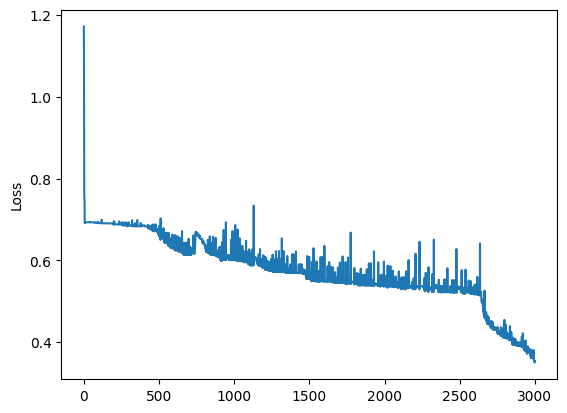

In [ ]:
plt.plot(losses_)
plt.ylabel('Loss')
plt.show()

#### After training

In [17]:
runner = bp.DSRunner(net, monitors={'r.spike': net.r.spike, 'r.membrane': net.r.V}, data_first_axis='T')
out = runner.run(inputs=x_data, reset_state=True)

Predict 500 steps: : 100%|██████████| 500/500 [00:00<00:00, 1487.04it/s]


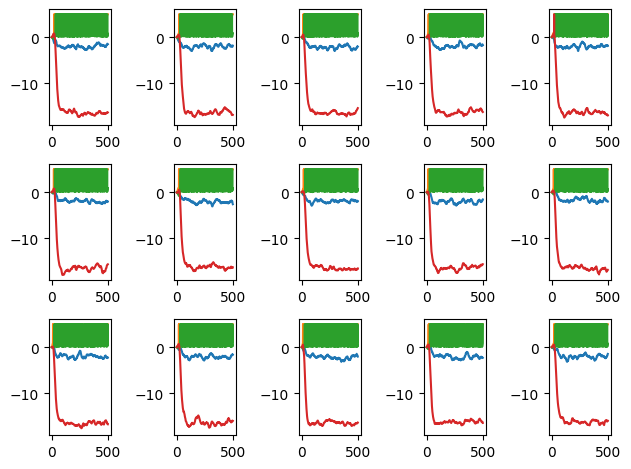

In [18]:
# recurrent membrane potential
plot_voltage_traces(runner.mon['r.membrane'], runner.mon['r.spike'])

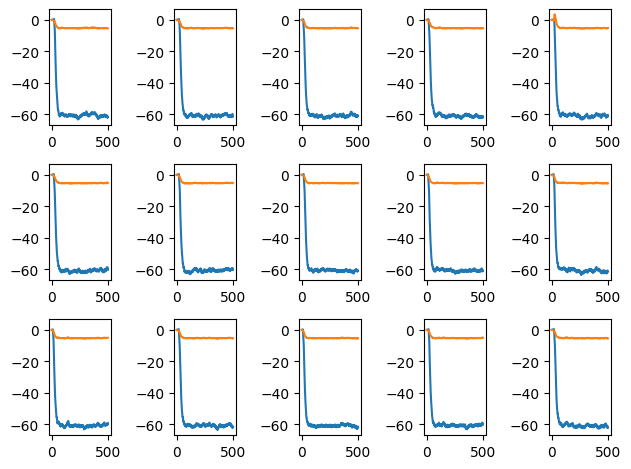

In [19]:
# output activity
plot_voltage_traces(out)

In [20]:
# classification accuracy
print_classification_accuracy(out, y_data)

Accuracy 0.633


# Fashion MNIST

In Tutorial 1, we have seen how to train a simple spiking neural network on a small synthetic dataset. In this tutorial, we will apply what we have learned so far to a slightly larger dataset.  

Concretely, we will use the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). 

In [21]:
train_dataset = bd.vision.FashionMNIST("./data", split='train', download=True)
test_dataset = bd.vision.FashionMNIST('./data', split='test', download=True)

26422272it [00:04, 5299643.08it/s]                              


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



29696it [00:00, 1385534.97it/s]          


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



4422656it [00:07, 578846.46it/s]                             


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



6144it [00:00, 14284813.62it/s]         

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [22]:
# Standardize data
x_train = np.array(train_dataset.data, dtype=bm.float_)
x_train = x_train.reshape(x_train.shape[0], -1) / 255
y_train = np.array(train_dataset.targets, dtype=bm.int_)
x_test = np.array(test_dataset.data, dtype=bm.float_)
x_test = x_test.reshape(x_test.shape[0], -1) / 255
y_test = np.array(test_dataset.targets, dtype=bm.int_)

In [23]:
num_input = 28 * 28
batch_size = 128

Network. 

In [24]:
with bm.environment(bm.TrainingMode(batch_size=batch_size)):
    net2 = SNN(num_in=num_input, num_rec=100, num_out=10, scale=10.)

### Dataset 

In [25]:
encoder = bp.encoding.LatencyEncoder(tau=20., threshold=0.2, method='log')

In [26]:
class Data2:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __call__(self):
        for i in range(0, self.X.shape[0], batch_size):
            X = self.X[i: i + batch_size]
            Y = self.Y[i: i + batch_size]
            yield encoder.multi_steps(X), bm.asarray(Y)

    def get_batch(self, i=0):
        X = self.X[i: i + batch_size]
        Y = self.Y[i: i + batch_size]
        return encoder.multi_steps(X), bm.asarray(Y)

### Training

In [ ]:
trainer = Trainer(net=net2, opt=bp.optim.Adam(lr=2e-3), data=Data2(x_train, y_train))
losses_ = trainer.f_train()

Train 0 epoch, loss = 0.8256, used time 10.3751 s
Train 1 epoch, loss = 0.5665, used time 9.1439 s
Train 2 epoch, loss = 0.5167, used time 8.6329 s
Train 3 epoch, loss = 0.4803, used time 8.2175 s
Train 4 epoch, loss = 0.4580, used time 7.9696 s
Train 5 epoch, loss = 0.4423, used time 7.6456 s
Train 6 epoch, loss = 0.4256, used time 7.5730 s
Train 7 epoch, loss = 0.4132, used time 7.4967 s
Train 8 epoch, loss = 0.4026, used time 7.3155 s
Train 9 epoch, loss = 0.3902, used time 7.3180 s
Train 10 epoch, loss = 0.3814, used time 7.6059 s
Train 11 epoch, loss = 0.3716, used time 7.9104 s
Train 12 epoch, loss = 0.3634, used time 7.7148 s
Train 13 epoch, loss = 0.3564, used time 7.6092 s
Train 14 epoch, loss = 0.3483, used time 7.8787 s
Train 15 epoch, loss = 0.3423, used time 8.0632 s
Train 16 epoch, loss = 0.3359, used time 8.0917 s
Train 17 epoch, loss = 0.3273, used time 8.3311 s
Train 18 epoch, loss = 0.3229, used time 8.1962 s
Train 19 epoch, loss = 0.3161, used time 8.0634 s
Train 20 

In [ ]:
def compute_classification_accuracy(model, x_data, y_data):
  """ Computes classification accuracy on supplied data in batches. """

  @bm.jit
  def f(X, Y):
      model.reset(X.shape[1])
      output = bm.for_loop(model.step_run, (np.arange(X.shape[0]), X))
      m = bm.max(output, 0)  # max over time
      am = bm.argmax(m, 1)  # argmax over output units
      tmp = bm.mean(Y == am)  # compare to labels
      return tmp
      
  accs = []
  for X, Y in Data2(x_data, y_data)():
      accs.append(f(X, Y))
  return np.mean(np.asarray(accs))

In [ ]:
print("Training accuracy: %.3f" % (compute_classification_accuracy(net2, x_train, y_train)))
print("Test accuracy: %.3f" % (compute_classification_accuracy(net2, x_test, y_test)))

Training accuracy: 0.896
Test accuracy: 0.847


### Visualization

In [ ]:
dataset = Data2(x_train, y_train)

In [ ]:
x_data = dataset.get_batch()[0]

runner = bp.DSRunner(net2, monitors={'r.spike': net2.r.spike, 'r.membrane': net2.r.V}, data_first_axis='T')
out = runner.run(inputs=x_data, reset_state=True)

  0%|          | 0/20 [00:00<?, ?it/s]

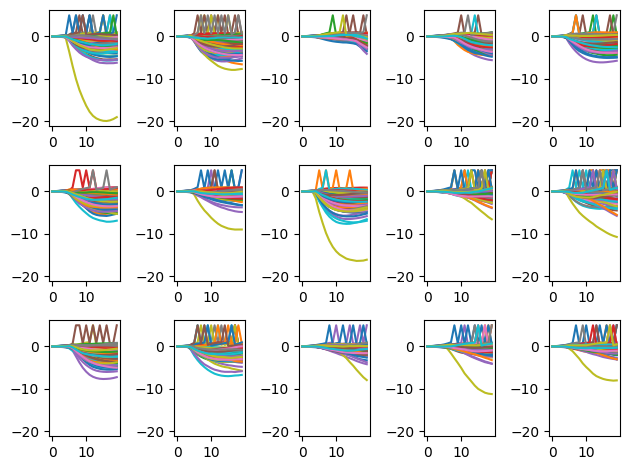

In [ ]:
# recurrent membrane potential
plot_voltage_traces(runner.mon['r.membrane'], runner.mon['r.spike'])